# Installs

In [ ]:
!git clone https://github.com/yurakuratov/t5-experiments.git

In [ ]:
!grep -v "^#" /content/t5-experiments/requirements.txt | xargs -n 1 -L 1 pip install

In [ ]:
!pip install tensorflow==2.6.0 tensorflow-estimator==2.6.0 tensorflow-text==2.6.0 tensorflow-io-gcs-filesystem==0.21.0 keras==2.6.0

In [ ]:
!HOROVOD_NCCL_HOME=... HOROVOD_GPU_OPERATIONS=NCCL HOROVOD_WITH_PYTORCH=1 pip install --no-cache-dir horovod[pytorch]==0.24.2 --no-binary=horovod

In [ ]:
!horovodrun --check-build

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!tar -xzvf "/content/drive/MyDrive/Colab Notebooks/Практика/lr1e-04_constant_with_warmup_adamw_wd1e-03_256.tar.gz"

lr1e-04_constant_with_warmup_adamw_wd1e-03_256/
lr1e-04_constant_with_warmup_adamw_wd1e-03_256/run_1/
lr1e-04_constant_with_warmup_adamw_wd1e-03_256/run_1/config.json
lr1e-04_constant_with_warmup_adamw_wd1e-03_256/run_1/events.out.tfevents.1655477799.v100x2-1-0.81888.0
lr1e-04_constant_with_warmup_adamw_wd1e-03_256/run_1/model_best.pth


In [ ]:
!tar -xvf "/content/drive/MyDrive/lr1e-04_constant_with_warmup_adamw_wd1e-03_1002_mem10_sum_loss.tar"

lr1e-04_constant_with_warmup_adamw_wd1e-03_1002_mem10_sum_loss/
lr1e-04_constant_with_warmup_adamw_wd1e-03_1002_mem10_sum_loss/run_1/
lr1e-04_constant_with_warmup_adamw_wd1e-03_1002_mem10_sum_loss/run_1/config.json
lr1e-04_constant_with_warmup_adamw_wd1e-03_1002_mem10_sum_loss/run_1/model_best.pth
lr1e-04_constant_with_warmup_adamw_wd1e-03_1002_mem10_sum_loss/run_1/events.out.tfevents.1658417243.gpu10.208729.0
lr1e-04_constant_with_warmup_adamw_wd1e-03_1002_mem10_sum_loss/run_1/.ipynb_checkpoints/
lr1e-04_constant_with_warmup_adamw_wd1e-03_1002_mem10_sum_loss/run_1/.ipynb_checkpoints/config-checkpoint.json


In [ ]:
!pip install simplejson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 5.0 MB/s 


In [ ]:
!pip install jsonlines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data

In [ ]:
!python "/content/drive/MyDrive/Colab Notebooks/Практика/hp_preprocess.py" \
--train-file "/content/drive/MyDrive/Colab Notebooks/Практика/articles-training-byarticle-20181122.xml" \
--labels-file "/content/drive/MyDrive/Colab Notebooks/Практика/ground-truth-training-byarticle-20181122.xml" \
--splits-file "/content/drive/MyDrive/Colab Notebooks/Практика/hp-splits.json" \
--output-dir data

loading articles...
loading labels...
preprocessing: 100% 645/645 [00:00<00:00, 874.26it/s]


In [ ]:
import torch
load_path = "/content/lr1e-04_constant_with_warmup_adamw_wd1e-03_256/run_1/model_best.pth"
checkpoint = torch.load(load_path, map_location='cpu')

In [ ]:
import json
import logging
import os
import re
import string
from pathlib import Path

# from megatron.data.dataset_utils import get_indexed_dataset_

import horovod.torch as hvd
from dotenv import load_dotenv
import torch
from torch.utils.data import DataLoader, DistributedSampler, Dataset
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# from trainer import Trainer, TrainerArgs

In [ ]:
hvd.init()

In [ ]:
hvd.rank()

0

In [ ]:
hvd.size()

1

In [ ]:
class HyperpartisanDataset(Dataset):
    def __init__(self, datafile, x_field='text', label_field='label'):
        if isinstance(datafile, str):
            # convert str path to folder to Path
            datafile = Path(datafile)
        self.data = []
        for line in datafile.open('r'):
            self.data += [json.loads(line)]
        self.x_field = x_field
        self.label_field = label_field

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][self.x_field]
        label = self.data[idx][self.label_field]
        return x, label


def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [ ]:
import transformers  # noqa: E402
from transformers import AutoConfig, AutoTokenizer, HfArgumentParser

tokenizer = AutoTokenizer.from_pretrained("t5-base")

/usr/local/lib/python3.7/dist-packages/cryptography/hazmat/backends/openssl/x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


In [ ]:
config = {
    "input_seq_len": 256,
    "target_seq_len": 192,
    "data_path": "/content/data/test.jsonl",
    "batch_size": 4,
    "gradient_accumulation_steps": 2,
    "data_n_workers": 1,
}

In [ ]:
global_attention_first_token = False  # should be True for LED
num_labels = 0
encode_plus_kwargs = {'truncation': True,
                        'padding': 'longest',
                        'pad_to_multiple_of': 1}
# generate predictions to fixed length
generate_kwargs = {'max_length': config["target_seq_len"], 'min_length': config["target_seq_len"]}
# generate predictions to max targets length in batch
generate_kwargs = {}

def collate_fn(batch):
    inputs, labels = zip(*batch)
    # if args.source_prefix:
    #     inputs = [args.source_prefix + inp for inp in inputs]
    features = tokenizer.batch_encode_plus(list(inputs), max_length=config["input_seq_len"],
                                            return_tensors='pt', **encode_plus_kwargs)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer.batch_encode_plus(list(labels), max_length=config["target_seq_len"],
                                                return_tensors='pt', **encode_plus_kwargs).input_ids
    labels[labels == tokenizer.pad_token_id] = -100
    features['labels'] = labels
    if 'global_attention_mask' in features:
        raise RuntimeError('What global attention mask for Longformer and LongformerEncoder-Decoder should be?')
    return features

In [ ]:
data_path = Path(config["data_path"]).expanduser().absolute()
train_dataset = HyperpartisanDataset(data_path)
# shuffle train data each epoch (one loop over train_dataset)
train_sampler = DistributedSampler(train_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=True,
                                    drop_last=False, seed=1234)
per_worker_batch_size = config["batch_size"] * config["gradient_accumulation_steps"]
global_batch_size = per_worker_batch_size * hvd.size()
kwargs = {'pin_memory': True, 'num_workers': config["data_n_workers"]}
train_dataloader = DataLoader(train_dataset, batch_size=per_worker_batch_size, sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)

In [ ]:
test_data_path = Path(config["data_path"]).expanduser().absolute()
test_dataset = HyperpartisanDataset(test_data_path)
test_sampler = DistributedSampler(test_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=per_worker_batch_size, sampler=test_sampler,
                                collate_fn=collate_fn, **kwargs)

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained("t5-base")
model.load_state_dict(checkpoint["model_state_dict"], strict=False)

/usr/local/lib/python3.7/dist-packages/cryptography/hazmat/backends/openssl/x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


_IncompatibleKeys(missing_keys=[], unexpected_keys=['lm_head.weight'])

In [ ]:
_ = model.eval()

In [ ]:
with torch.no_grad():
    for batch in test_dataloader:
        pred = model(
            input_ids=batch["input_ids"], 
            attention_mask=batch["attention_mask"], 
            decoder_input_ids=batch["labels"],
            output_attentions=True
            )
        print(pred)
        break

In [ ]:
pred["encoder_attentions"][0].shape

torch.Size([8, 12, 256, 256])

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

def plot_attention_weights(attentions, tokens, layer, y_tokens=None, p_attentions=None, filename='att.png', save=False):
    # attentions n_layers x n_heads x len x len
    fig = plt.figure(figsize=(30, 30))
    if y_tokens is None:
        y_tokens = tokens
        fig = plt.figure(figsize=(30, 90))

    attention = attentions[layer]
    if p_attentions:
        p_attention = p_attentions[layer]

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(6, 2, head+1)

        # plot the attention weights
        if p_attentions:
            att = np.concatenate([np.expand_dims(p_attention[head], axis=0), attention[head]], axis=0)
            ax.matshow(att[:len(y_tokens)+1,:len(tokens)], cmap='Reds')
        else:
            ax.matshow(attention[head][:len(y_tokens),:len(tokens)], cmap='Reds')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(tokens)))
        if p_attentions:
            ax.set_yticks(range(len(y_tokens) + 1))
            ax.set_yticklabels(['[P]'] + y_tokens, fontdict)
        else:
            ax.set_yticks(range(len(y_tokens)))
            ax.set_yticklabels(y_tokens, fontdict)

        ax.set_xticklabels(tokens,fontdict=fontdict, rotation=90)

        ax.set_xlabel('Head {}'.format(head+1), fontdict)

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

In [ ]:
pred["encoder_attentions"][0][0].shape

torch.Size([12, 256, 256])

In [ ]:
tokens = [tokenizer.convert_ids_to_tokens(t_id).replace('▁', '') for t_id in batch["input_ids"][0].tolist()]

In [ ]:
attentions = [layer_atts[0].detach().squeeze().numpy() if layer_atts[0] is not None else None for layer_atts in pred['encoder_attentions']]
attentions[0].shape

(12, 256, 256)

<Figure size 2160x2160 with 0 Axes>

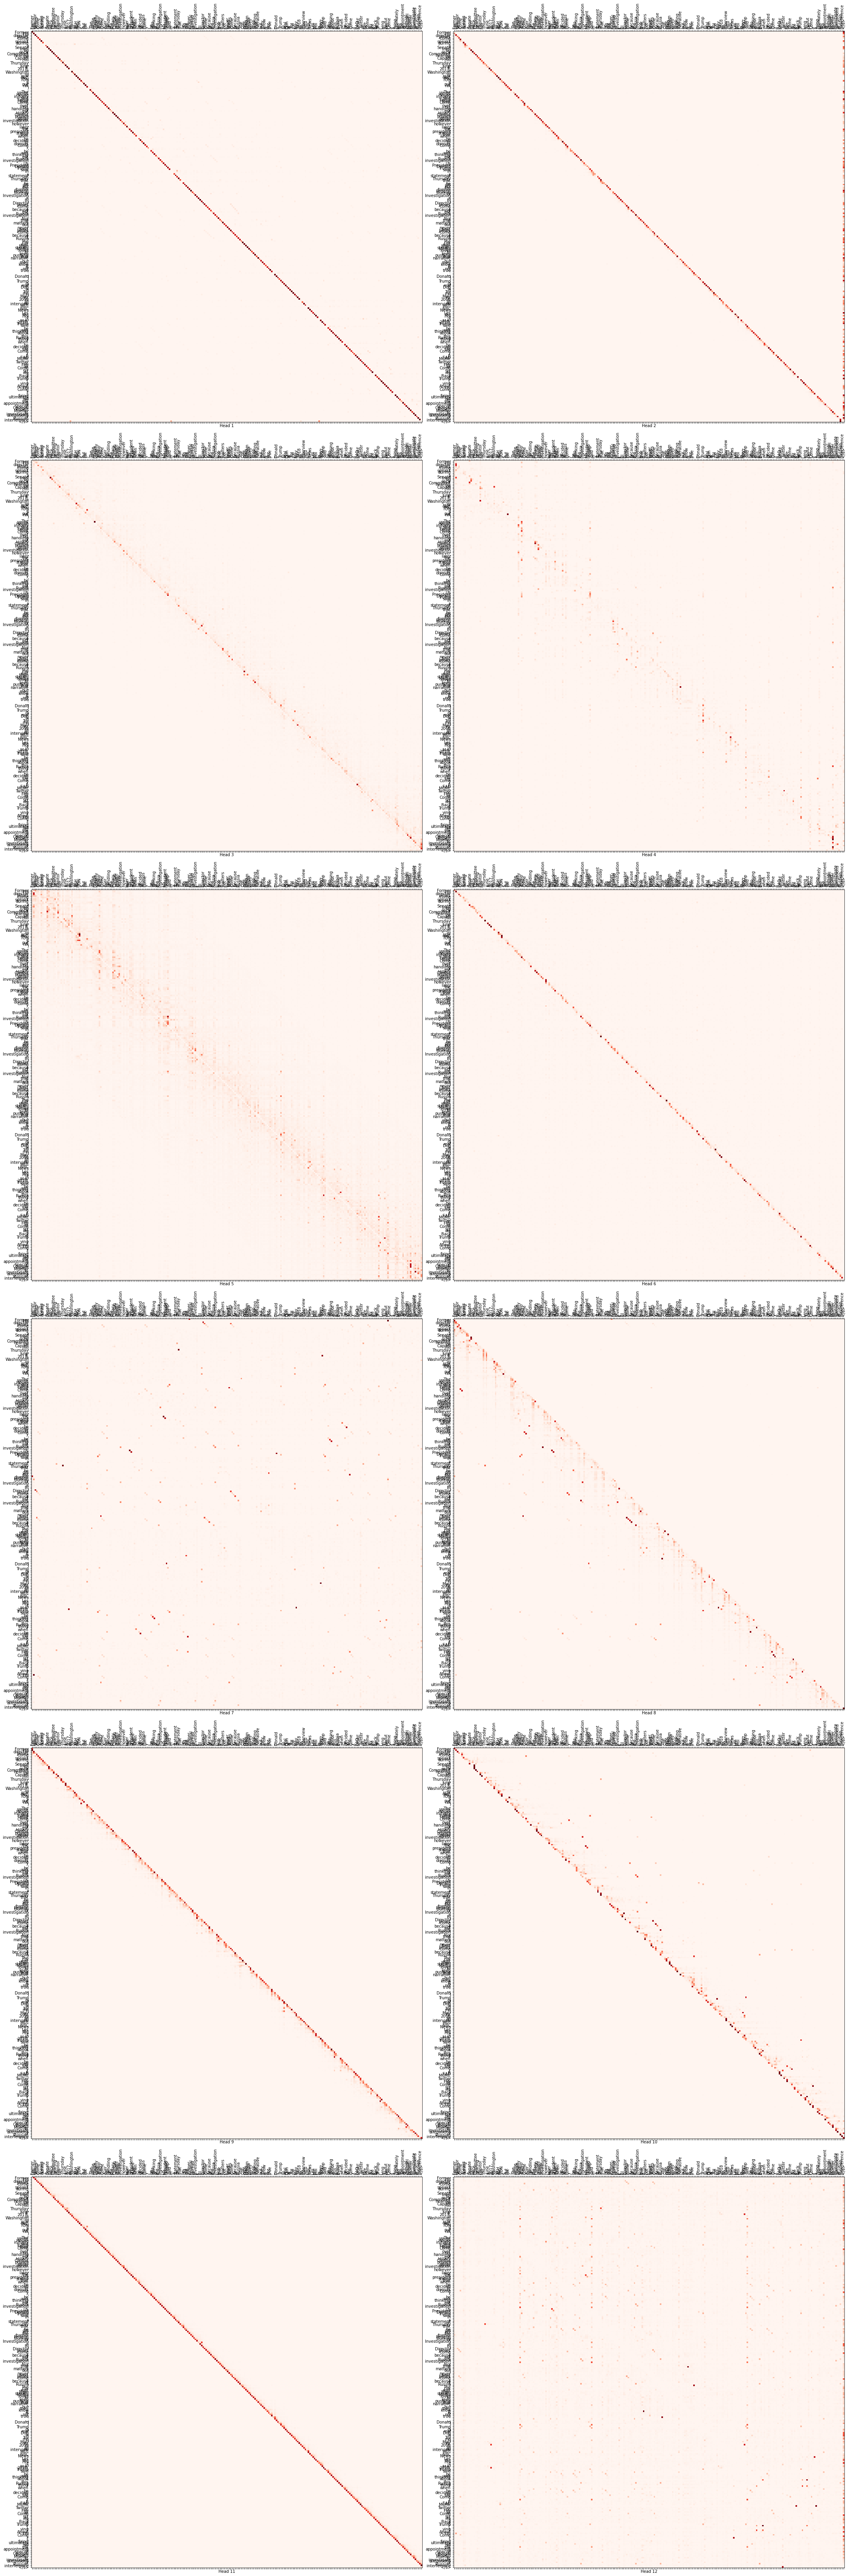

In [ ]:
plot_attention_weights(attentions, tokens=tokens, layer=0, y_tokens=None, p_attentions=None)

- разные примеры
- разные слои
- разные головы
- среднее по слою/для одной головы на разных примерах(продумать что-то кроме среднего, мб взвешенное)

In [ ]:
!pip install bertviz

In [ ]:
import torch
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union
from transformers import PreTrainedModel, AutoModel
# from modeling_t5 import T5ForConditionalGeneration

import math

SEGMENTABLE = ['input_ids', 'inputs_embeds', 'token_type_ids', 'position_ids', 'attention_mask']
PAD_ZEROS = ['token_type_ids', 'attention_mask']


class RMTEncoderDecoderForConditionalGeneration():
    def __init__(self, config=None, base_model=None, **kwargs):
        if config is not None:
            self.config = config
            self.model = AutoModel(config, **kwargs)
        
        if base_model is not None:
            self.model = base_model


    def from_pretrained(from_pretrained, **kwargs):
        # print(f'Creating from pretrained: {from_pretrained}')
        base_model = AutoModel.from_pretrained(from_pretrained, **kwargs)
        rmt = RMTEncoderDecoderForConditionalGeneration(base_model=base_model)
        rmt.from_pretrained = from_pretrained
        return rmt
        

    def set_params(self, 
                    model_attr='', 
                    drop_empty_segments=True,
                    sum_loss=False,
                    backbone_cls=None,
                    input_size=None, 
                    input_seg_size=None, 
                    num_mem_tokens=0, 
                    bptt_depth=-1, 
                    pad_token_id=0, 
                    eos_token_id=1,
                    cls_token_id=101, 
                    sep_token_id=102):
        # print('model attr: ', model_attr)

        if backbone_cls is not None:
            self.model = backbone_cls.from_pretrained(self.from_pretrained)

        if model_attr:
            self.encoder = getattr(self.model, model_attr).encoder
        else:
            self.encoder = self.model.encoder
        self.embeddings = self.encoder.embed_tokens
        self.input_size = self.embeddings.weight.shape[0] if input_size is None else input_size
        self.input_seg_size = input_seg_size

        self.bptt_depth = bptt_depth
        self.pad_token_id = pad_token_id
        self.eos_token = torch.tensor([eos_token_id])
        # print(pad_token_id, eos_token_id)
        self.num_mem_tokens = num_mem_tokens
        self.drop_empty_segments = drop_empty_segments
        self.sum_loss = sum_loss
        self.extend_word_embeddings()
        

    def set_memory(self, memory=None):
        if memory is None:
            mem_token_ids = self.mem_token_ids.to(device=self.device)
            # print('setting memory')
            # print('mem_token_ids', mem_token_ids.shape)
            memory = self.embeddings(mem_token_ids)
            # print('memory', memory.shape)
        return memory
    
    def extend_word_embeddings(self):
        vocab_size = self.embeddings.weight.shape[0]
        extended_vocab_size = vocab_size + self.num_mem_tokens
        self.mem_token_ids = torch.arange(vocab_size, vocab_size + self.num_mem_tokens)
        self.resize_token_embeddings(extended_vocab_size)
        self.embeddings = self.encoder.embed_tokens
        # print('extended_vocab_size', extended_vocab_size)
        # print('self.embeddings', self.embeddings.weight.shape)
        # print('self.mem_token_ids', self.mem_token_ids)


    def __call__(self, input_ids, **kwargs):
        memory = self.set_memory()
        segmented = self.pad_and_segment(input_ids)

        outputs = []
        for seg_num, segment_data in enumerate(zip(*segmented)):
            input_ids, attention_mask, token_type_ids = segment_data
            if memory.ndim == 2:
                memory = memory.repeat(input_ids.shape[0], 1, 1)
            if (self.bptt_depth > -1) and (len(segmented) - seg_num > self.bptt_depth): 
                memory = memory.detach()

            seg_kwargs = dict(**kwargs)
            if self.drop_empty_segments:
                non_empty_mask = [not torch.equal(input_ids[i], self.empty) for i in range(len(input_ids))]
                if sum(non_empty_mask) == 0:
                    continue
                input_ids = input_ids[non_empty_mask]
                attention_mask = attention_mask[non_empty_mask]
                token_type_ids = token_type_ids[non_empty_mask]
                seg_kwargs['labels'] = seg_kwargs['labels'][non_empty_mask]

                inputs_embeds = self.embeddings(input_ids)
                inputs_embeds[:, 1:1+self.num_mem_tokens] = memory[non_empty_mask]

            else:
                inputs_embeds = self.embeddings(input_ids)
                inputs_embeds[:, 1:1+self.num_mem_tokens] = memory

            seg_kwargs['inputs_embeds'] = inputs_embeds
            seg_kwargs['attention_mask'] = attention_mask

            out = self.model.forward(**seg_kwargs, output_hidden_states=True)
            outputs.append(out)
            
            if self.drop_empty_segments:
                memory[non_empty_mask] = out.encoder_hidden_states[-1][:, :self.num_mem_tokens]
            else:
                memory = out.encoder_hidden_states[-1][:, :self.num_mem_tokens]
            # print('out', out.keys())
            # print('memory3',  memory.shape)

        if self.sum_loss:
            out['loss'] = torch.stack([o['loss'] for o in outputs]).sum(dim=-1)

        return out


    def generate(self, input_ids, **kwargs):
        memory = self.set_memory()
        segmented = self.pad_and_segment(input_ids)
        min_length, max_length = None, None
        if 'min_length' in kwargs:
            min_length = kwargs.pop('min_length')
        if 'max_length' in kwargs:
            max_length = kwargs.pop('max_length')
        for seg_num, segment_data in enumerate(zip(*segmented)):
            input_ids, attention_mask, token_type_ids = segment_data
            if memory.ndim == 2:
                memory = memory.repeat(input_ids.shape[0], 1, 1)
            if (self.bptt_depth > -1) and (len(segmented) - seg_num > self.bptt_depth): 
                memory = memory.detach()

            seg_kwargs = dict(**kwargs)
            if self.drop_empty_segments:
                non_empty_mask = [not torch.equal(input_ids[i], self.empty) for i in range(len(input_ids))]
                if sum(non_empty_mask) == 0:
                    continue
                input_ids = input_ids[non_empty_mask]
                attention_mask = attention_mask[non_empty_mask]
                token_type_ids = token_type_ids[non_empty_mask]

                inputs_embeds = self.embeddings(input_ids)
                inputs_embeds[:, 1:1+self.num_mem_tokens] = memory[non_empty_mask]

            else:
                inputs_embeds = self.embeddings(input_ids)
                inputs_embeds[:, 1:1+self.num_mem_tokens] = memory
                
            seg_kwargs['inputs_embeds'] = inputs_embeds
            seg_kwargs['attention_mask'] = attention_mask
            if seg_num < len(segmented[0])-1:
                labels = torch.zeros(inputs_embeds.shape[0], inputs_embeds.shape[1], device=inputs_embeds.device, dtype=input_ids.dtype)
                out = self.model.forward(**seg_kwargs, output_hidden_states=True, labels=labels)
                if self.drop_empty_segments:
                    memory[non_empty_mask] = out.encoder_hidden_states[-1][:, :self.num_mem_tokens]
                else:
                    memory = out.encoder_hidden_states[-1][:, :self.num_mem_tokens]
            else:
                out = self.model.generate(**seg_kwargs, output_hidden_states=True, min_length=min_length, max_length=max_length)
            
        return out

    def pad_and_segment(self, input_ids):
        
        sequence_len = input_ids.shape[1]
        input_seg_size = self.input_size - self.num_mem_tokens - 1
        if self.input_seg_size is not None and self.input_seg_size < input_seg_size:
            input_seg_size = self.input_seg_size
            
        n_segments = math.ceil(sequence_len / input_seg_size)

        augmented_inputs = []
        for input in input_ids:
            # print('input != self.pad_token_id ', (input != self.pad_token_id).shape, (input != self.pad_token_id).sum())
            # 1/0
            input = input[input != self.pad_token_id][1:-1]

            seg_sep_inds = [0] + list(range(len(input), 0, -input_seg_size))[::-1] # chunk so that first segment has various size
            input_segments = [input[s:e] for s, e in zip(seg_sep_inds, seg_sep_inds[1:])]

            def pad_add_special_tokens(tensor, seg_size):
                tensor = torch.cat([
                                    # self.cls_token.to(device=self.device),
                                    self.mem_token_ids.to(device=self.device),
                                    # self.sep_token.to(device=self.device),
                                    tensor.to(device=self.device),
                                    # self.sep_token.to(device=self.device),
                                    self.eos_token.to(device=self.device)
                                    ])
                pad_size = seg_size - tensor.shape[0]
                if pad_size > 0:
                    tensor = F.pad(tensor, (0, pad_size))
                return tensor

            input_segments = [pad_add_special_tokens(t, self.input_size) for t in input_segments]
            empty = torch.Tensor([]).int()
            self.empty = pad_add_special_tokens(empty, self.input_size)
            empty_segments = [self.empty for i in range(n_segments - len(input_segments))]
            input_segments = empty_segments + input_segments

            augmented_input = torch.cat(input_segments)
            augmented_inputs.append(augmented_input)
            
        augmented_inputs = torch.stack(augmented_inputs)
        attention_mask = torch.ones_like(augmented_inputs)
        attention_mask[augmented_inputs == self.pad_token_id] = 0

        token_type_ids = torch.zeros_like(attention_mask)

        input_segments = torch.chunk(augmented_inputs, n_segments, dim=1)
        attention_mask = torch.chunk(attention_mask, n_segments, dim=1)
        token_type_ids = torch.chunk(token_type_ids, n_segments, dim=1)
    
        return input_segments, attention_mask, token_type_ids


    def to(self, device):
        self.model = self.model.to(device)
        
    
    def cuda(self):
        self.model.cuda()


    def __getattr__(self, attribute):
        return getattr(self.model, attribute)


    def parameters(self, **kwargs):
        return self.model.parameters(**kwargs)

    def named_parameters(self, **kwargs):
        return self.model.named_parameters(**kwargs)

In [ ]:
load_path_rmt = "/content/lr1e-04_constant_with_warmup_adamw_wd1e-03_1002_mem10_sum_loss/run_1/model_best.pth"
checkpoint_rmt = torch.load(load_path_rmt, map_location='cpu')
model_rmt = RMTEncoderDecoderForConditionalGeneration.from_pretrained("t5-base")
model_rmt.set_params(num_mem_tokens=10, 
                input_size=512,
                input_seg_size=1002,
                model_attr=None,
                # backbone_cls=transformers.BartForConditionalGeneration,
                bptt_depth=-1, 
                pad_token_id=tokenizer.pad_token_id,
                cls_token_id=tokenizer.cls_token_id, 
                sep_token_id=tokenizer.sep_token_id,
                eos_token_id=tokenizer.eos_token_id,)
model_rmt.load_state_dict(checkpoint_rmt["model_state_dict"], strict=False)
_ = model_rmt.eval()

<Figure size 2160x2160 with 0 Axes>

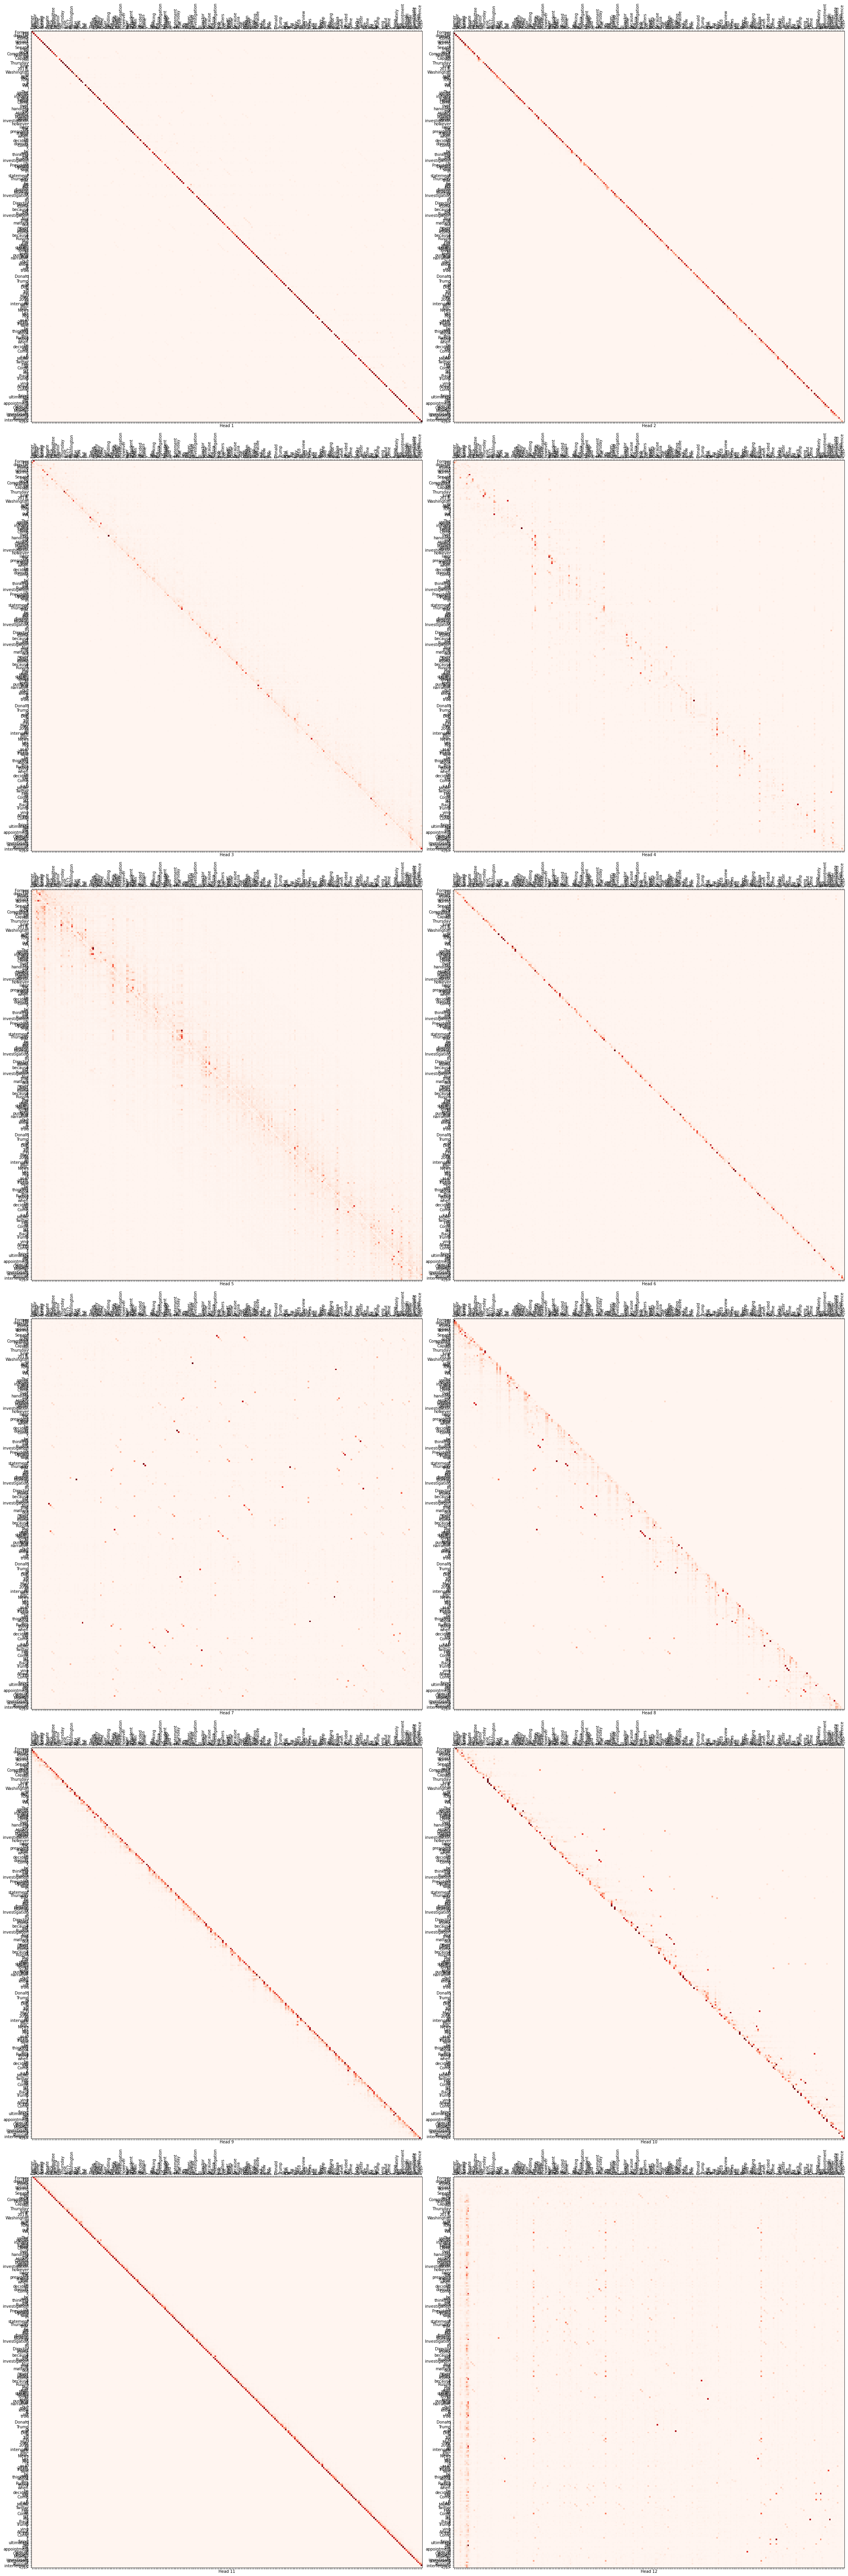

In [ ]:
with torch.no_grad():
    for batch in test_dataloader:
        pred = model_rmt(#**batch,
            input_ids=batch["input_ids"], 
            attention_mask=batch["attention_mask"], 
            decoder_input_ids=batch["labels"],
            output_attentions=True
            )
        break

tokens = [tokenizer.convert_ids_to_tokens(t_id).replace('▁', '') for t_id in batch["input_ids"][0].tolist()]
attentions = [layer_atts[0].detach().squeeze().numpy() if layer_atts[0] is not None else None for layer_atts in pred['encoder_attentions']]
plot_attention_weights(attentions, tokens=tokens, layer=0, y_tokens=None, p_attentions=None, save=True)
